In [1]:
# -*- coding: utf-8 -*-
"""
End-to-end runner for:
  1) Data stats
  2) Model performance (K-Fold + optional LOO)
  3) Feature importance via Grad×Input (per cumulative block)
  4) Saliency heatmaps

"""
from __future__ import annotations
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from ecog_lstm import (
    Config,
    preprocess_and_build_sequences,
    run_time_increasing_kfold,
    run_time_increasing_loo,
    plot_hourly_epilepsy_distribution,
    run_saliency_only,
    topk_table_per_block,
    plot_saliency_heatmap_from_out,
)


def ensure_outdir(path: str | Path) -> Path:
    p = Path(path); p.mkdir(parents=True, exist_ok=True); return p


def data_stats(cfg: Config, out_dir: Path) -> None:
    X, y, feats, pids, T = preprocess_and_build_sequences(cfg)
    print("\n====== DATA STATS ======")
    print(f"Patients: N={len(pids)} (pos={(y==1).sum()}, neg={(y==0).sum()})")
    print(f"Time steps: T={T} (step={cfg.step_minutes}min); Features: F={len(feats)}")
    for mode in ("usable_cumulative", "valid_exact"):
        df = plot_hourly_epilepsy_distribution(cfg, mode=mode, normalize=False,
                                               save_prefix=str(out_dir / f"hourly_{mode}"))
        print(f"Saved hourly distribution for mode={mode}: {out_dir / f'hourly_{mode}_{cfg.step_minutes}min_{int(cfg.start_hr)}_{int(cfg.end_hr)}.csv'}")


def model_performance(cfg: Config, out_dir: Path, do_loo: bool = False) -> tuple[pd.DataFrame, pd.DataFrame | None]:
    print("\n====== MODEL PERFORMANCE (K-Fold) ======")
    df_k = run_time_increasing_kfold(cfg, n_splits=5, repeats=1, plot_curves=True)
    df_k_path = out_dir / cfg.out_csv.replace('.csv', '_5fold.csv')
    if df_k_path.exists():
        print(f"K-Fold metrics → {df_k_path}")
    df_l = None
    if do_loo:
        print("\n====== MODEL PERFORMANCE (LOO) ======")
        df_l = run_time_increasing_loo(cfg)
        df_l_path = out_dir / cfg.out_csv.replace('.csv', '_loo.csv')
        if df_l_path.exists():
            print(f"LOO metrics → {df_l_path}")
    return df_k, df_l


def save_perf_plots_kfold(df_k: pd.DataFrame, out_png: Path, title: str):
    import numpy as np
    x = df_k['time_hr'].values
    plt.figure(figsize=(9,5))
    for key, label in [("AUC", "AUC"), ("ACC", "Accuracy"), ("ACC0", "Acc class 0"), ("ACC1", "Acc class 1")]:
        m = df_k[f'{key}_mean'].values
        s = df_k[f'{key}_std'].values
        plt.plot(x, m, label=label)
        if np.isfinite(s).any():
            plt.fill_between(x, m - s, m + s, alpha=0.15)
    plt.xlabel('Hours since start'); plt.ylabel('Score')
    plt.title(title)
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.savefig(out_png, dpi=160); plt.close()


def feature_importance_and_heatmaps(cfg: Config, out_dir: Path,
                                    blocks: list[int],
                                    topk: int = 15,
                                    heatmap_blocks: list[int] | None = None,
                                    train_epochs: int = 20,
                                    batch_size: int | None = None) -> pd.DataFrame:
    print("\n====== FEATURE IMPORTANCE (Grad×Input) ======")
    out = run_saliency_only(
        cfg,
        blocks=blocks,
        saliency_abs=True,
        train_epochs=train_epochs,
        batch_size=batch_size,
        return_trained_model=False,
    )
    sal_df = out['saliency_df']
    sal_path = out_dir / 'saliency_per_block.csv'
    sal_df.to_csv(sal_path, index=False)
    print(f"Saved saliency table → {sal_path}")
    top_df = topk_table_per_block(sal_df, value_col='norm_importance', k=topk)
    top_path = out_dir / f'top{topk}_per_block.csv'
    top_df.to_csv(top_path, index=False)
    print(f"Saved top-{topk} per block → {top_path}")
    if heatmap_blocks is None:
        heatmap_blocks = [b for b in blocks if b % 24 == 0][:4] or blocks[:4]
    hm_dir = ensure_outdir(out_dir / 'heatmaps')
    for be in heatmap_blocks:
        png = hm_dir / f'heatmap_cumulative_to_{be}h.png'
        plot_saliency_heatmap_from_out(out, block_end_hr=be, sample_reduce="mean",
                                       clip_percentile=99.0, figsize=(14, 6),
                                       save_path=str(png), show=False, cfg=cfg)
        print(f"Saved heatmap → {png}")
    return sal_df


In [2]:
DATA_CSV_60 = "Data/all_patients_60min_aggregated.csv"
DATA_CSV_10 = "Data/all_patients_10min_aggregated.csv"
ROOT_OUT = ensure_outdir("outputs_lstm")

out60 = ensure_outdir(ROOT_OUT / 'time60min')
out10 = ensure_outdir(ROOT_OUT / 'time10min')

FEATURE_LIST = ['SignalSD', 'lv_l5', 'lv_l10', 'lv_l20', 'SIQ', 'SIQ_delta', 'SIQ_theta', 'SIQ_alpha',
 'SIQ_beta', 'BCI', 'BSAR', 'd0MaxAmp', 'd0MeanMaxAmp', 'd0VarMaxAmp', 'd0VarMeanAmp', 'd0VarVarAmp',
 'd0MeanVarAmp', 'd0MaxMaxFourAmp', 'd0MeanMaxFourAmp', 'd0VarMaxFourAmp', 'd1MaxAmp', 'd1MeanMaxAmp',
 'd1VarMaxAmp', 'd1VarMeanAmp', 'd1VarVarAmp', 'd1MeanVarAmp', 'd1MaxMaxFourAmp', 'd1MeanMaxFourAmp',
 'd1VarMaxFourAmp', 'd2MaxAmp', 'd2MeanMaxAmp', 'd2VarMaxAmp', 'd2VarMeanAmp', 'd2VarVarAmp',
 'd2MeanVarAmp', 'd2MaxMaxFourAmp', 'd2MeanMaxFourAmp', 'd2VarMaxFourAmp', 'linelengthmean', 'kurtavg',
 'shanavg', 'nlemean', 'nleavgstd', 'deltakurtosis', 'thetakurtosis', 'alphakurtosis', 'betakurtosis',
 'deltameanrat', 'thetameanrat', 'alphameanrat', 'betameanrat', 'deltaminrat', 'thetaminrat',
 'alphaminrat', 'betaminrat', 'deltastdrat', 'thetastdrat', 'alphastdrat', 'betastdrat', 'deltapctrat',
 'thetapctrat', 'alphapctrat', 'betapctrat', 'deltathetamean', 'deltaalphamean', 'thetaalphamean',
 'deltathetamin', 'deltaalphamin', 'thetaalphamin', 'deltathetastd', 'deltaalphastd', 'thetaalphastd',
 'deltathetapct', 'deltaalphapct', 'thetaalphapct', 'meanlogentropy', 'xcorrmean', 'xcorrstd', 'corrmean',
 'geomeanamp', 'harmmeanamp', 'meanskewamp', 'stdskewamp', 'overallskewamp', 'meaniqrchannelamp',
 'overalliqramp', 'avgspectent', 'sdspectent', 'pctchangepoint', 'pctpeakpoint', 'avgspectkurt',
 'sdspectkurt', 'meanrms', 'sdrms']

# ----------- 60-min configuration -----------


===== RUN @60min =====
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=109 (step=60min), F=94

====== DATA STATS ======
Patients: N=69 (pos=17, neg=52)
Time steps: T=109 (step=60min); Features: F=94
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=109 (step=60min), F=94
[OK] Saved hourly label distribution: outputs_lstm\time60min\hourly_usable_cumulative_usable_cumulative_60min_12_120.csv


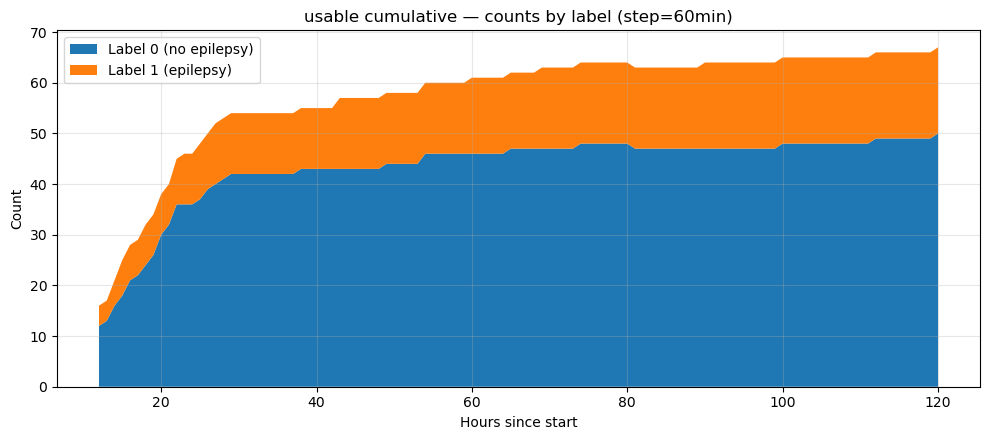

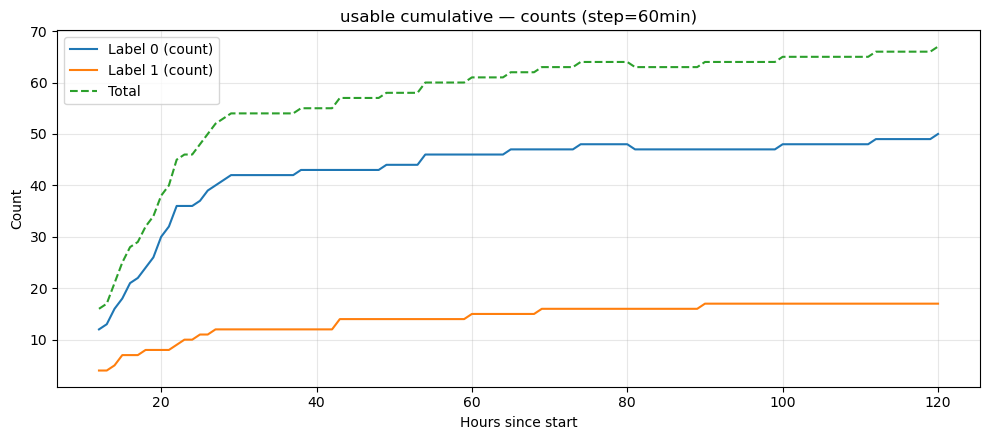

Saved hourly distribution for mode=usable_cumulative: outputs_lstm\time60min\hourly_usable_cumulative_60min_12_120.csv
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=109 (step=60min), F=94
[OK] Saved hourly label distribution: outputs_lstm\time60min\hourly_valid_exact_valid_exact_60min_12_120.csv


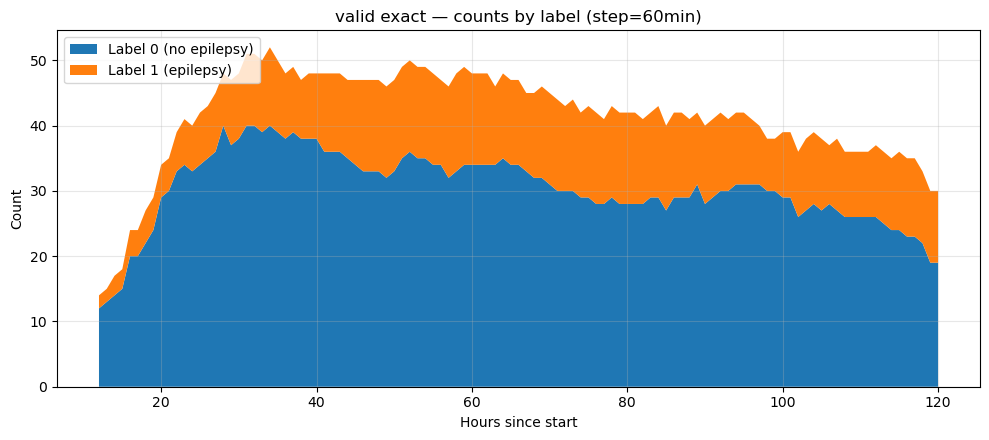

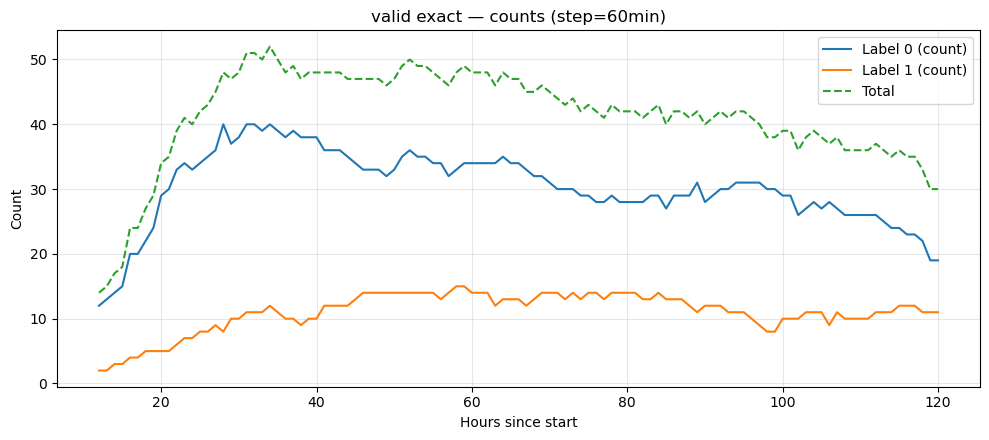

Saved hourly distribution for mode=valid_exact: outputs_lstm\time60min\hourly_valid_exact_60min_12_120.csv

====== MODEL PERFORMANCE (K-Fold) ======
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=109 (step=60min), F=94
[Info][KFold] Device: cuda, N=69, T=109, F=94, step=60min, stride=5.0hr, folds=5, repeats=1
[OK] K-fold metrics saved: outputs_lstm/time60min/has_epilepsy_lstm_60min_5fold.csv                                               


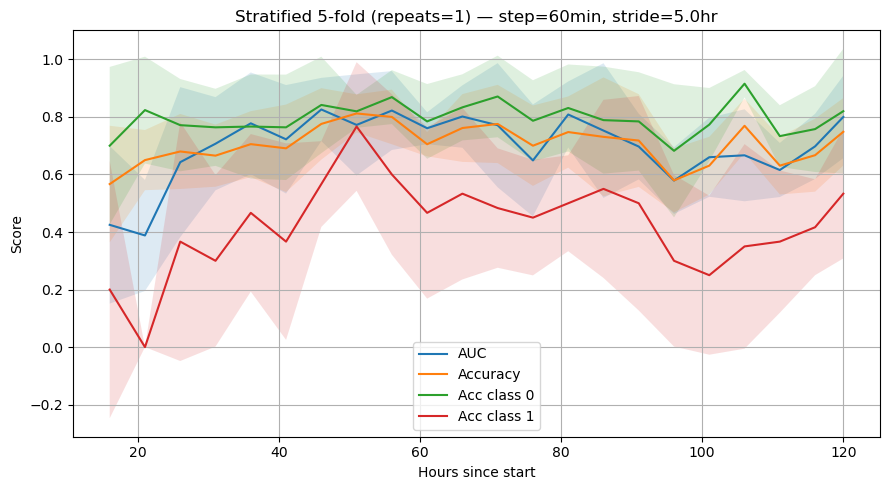


====== FEATURE IMPORTANCE (Grad×Input) ======
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=109 (step=60min), F=94
Saved saliency table → outputs_lstm\time60min\saliency_per_block.csv
Saved top-15 per block → outputs_lstm\time60min\top15_per_block.csv
Saved heatmap → outputs_lstm\time60min\heatmaps\heatmap_cumulative_to_24h.png
Saved heatmap → outputs_lstm\time60min\heatmaps\heatmap_cumulative_to_48h.png
Saved heatmap → outputs_lstm\time60min\heatmaps\heatmap_cumulative_to_72h.png
Saved heatmap → outputs_lstm\time60min\heatmaps\heatmap_cumulative_to_120h.png


In [7]:
cfg60 = Config(
    path_csv=DATA_CSV_60, # input data path (60-min resolution)
    start_hr=12, # window start hour (post-ROSC)
    end_hr=120, # window end hour (post-ROSC)
    step_minutes=60, # sampling step (minutes)
    features=FEATURE_LIST, # EEG feature list
    eval_stride_hr=5.0, # evaluation stride (hours)
    epochs=60, # training epochs per fold
    batch_size=64, # batch size (fits GPU memory)
    hidden_size=64, # LSTM hidden dimension
    num_layers=2, # LSTM layers
    bidirectional=True, # use BiLSTM
    dropout=0.3, # dropout rate
    out_csv="outputs_lstm/time60min/has_epilepsy_lstm_60min.csv", # output metrics file
    use_duplication=True, # balance positive/negative classes
    use_pos_weight=True, # apply pos_weight in BCE loss
    restrict_to_intersection=True, # keep only features common across patients
    min_patient_coverage=0.95, # feature presence threshold per patient
    min_nonzero_frac=0.10, # minimum active fraction per sequence
)

print("\n===== RUN @60min =====")
data_stats(cfg60, out60)
dfk60, _ = model_performance(cfg60, out60, do_loo=False)
save_perf_plots_kfold(dfk60, out60/"perf_kfold.png",
                        title=f"K-Fold Performance — 60min (stride={cfg60.eval_stride_hr}h)")
BLOCKS = list(range(12, 121, 12))
_sal60 = feature_importance_and_heatmaps(
    cfg60, out60,
    blocks=BLOCKS,
    topk=15,
    heatmap_blocks=[24, 48, 72, 120],
    train_epochs=20,
    batch_size=32,
)

# ----------- 10-min configuration -----------


===== RUN @10min =====
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=649 (step=10min), F=94

====== DATA STATS ======
Patients: N=69 (pos=17, neg=52)
Time steps: T=649 (step=10min); Features: F=94
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=649 (step=10min), F=94
[OK] Saved hourly label distribution: outputs_lstm\time10min\hourly_usable_cumulative_usable_cumulative_10min_12_120.csv


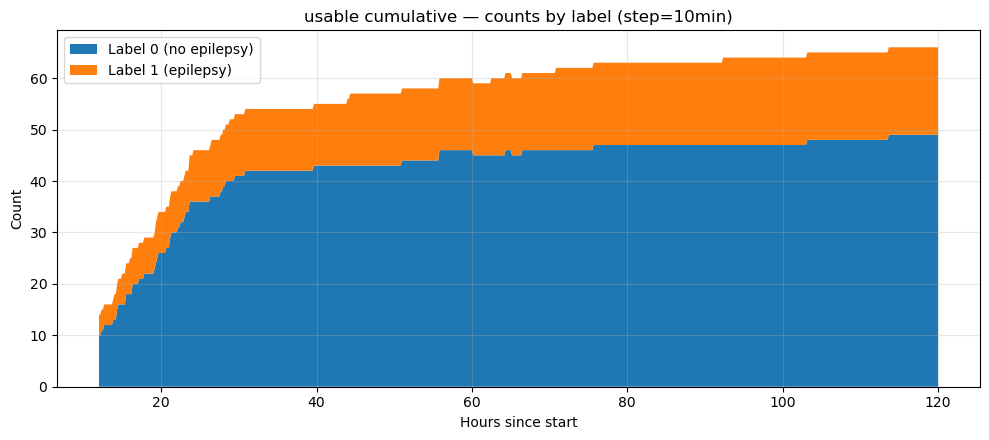

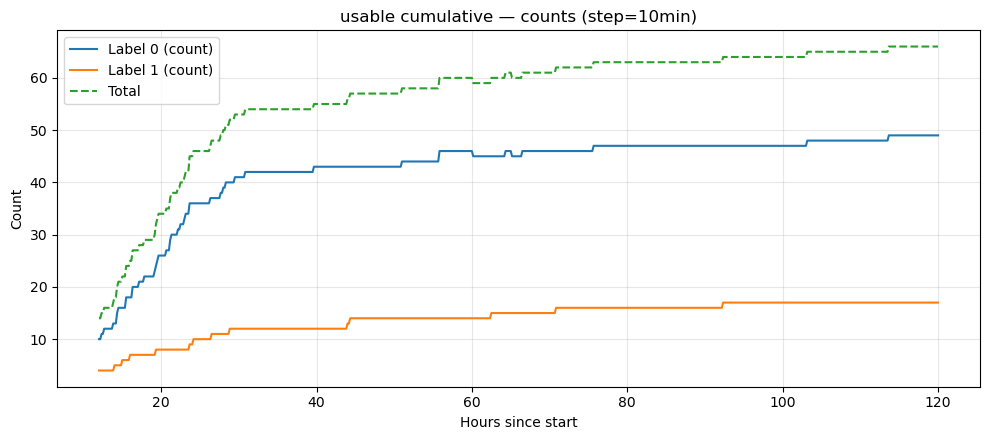

Saved hourly distribution for mode=usable_cumulative: outputs_lstm\time10min\hourly_usable_cumulative_10min_12_120.csv
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=649 (step=10min), F=94
[OK] Saved hourly label distribution: outputs_lstm\time10min\hourly_valid_exact_valid_exact_10min_12_120.csv


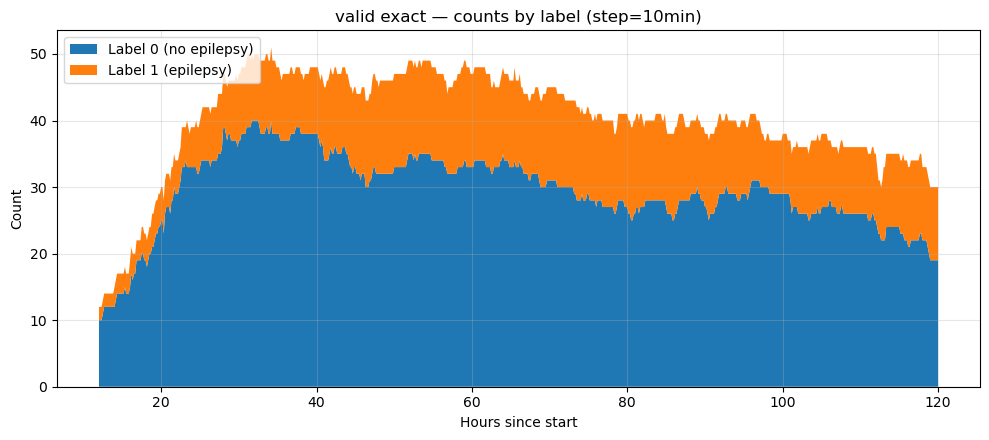

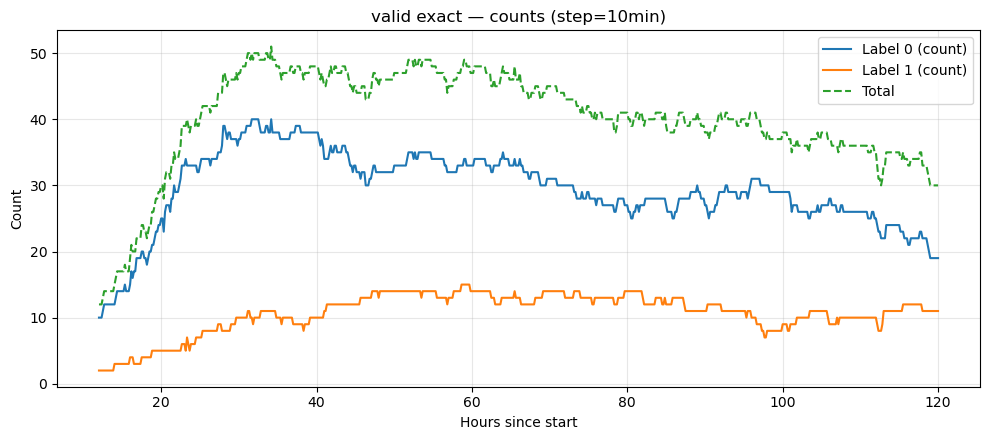

Saved hourly distribution for mode=valid_exact: outputs_lstm\time10min\hourly_valid_exact_10min_12_120.csv

====== MODEL PERFORMANCE (K-Fold) ======
[Info] Explicit features requested: 94, present: 94
[Info] Kept after coverage intersection: 94 / 94 (threshold=0.95)
[Info] Final feature dimension: 94
[Info] Patient distribution: positive=17, negative=52, total=69
[Info] Tensor shapes: N=69, T=649 (step=10min), F=94
[Info][KFold] Device: cuda, N=69, T=649, F=94, step=10min, stride=5.0hr, folds=5, repeats=1
Time steps (KFold):  73%|█████████████████████████████████████████████████████                    | 16/22 [01:00<00:27,  4.58s/it]

In [ ]:
cfg10 = Config(
    path_csv=DATA_CSV_10, # input data path (10-min resolution)
    start_hr=12, # window start hour (post-ROSC)
    end_hr=120, # window end hour (post-ROSC)
    step_minutes=10, # sampling step (minutes)
    features=FEATURE_LIST, # EEG feature list
    eval_stride_hr=5.0, # evaluation stride (hours)
    epochs=60, # training epochs per fold
    batch_size=32, # batch size (adjusted for longer T)
    hidden_size=64, # LSTM hidden dimension
    num_layers=2, # LSTM layers
    bidirectional=True, # use BiLSTM
    dropout=0.3, # dropout rate
    out_csv="outputs_lstm/time10min/has_epilepsy_lstm_10min.csv", # output metrics file
    use_duplication=True, # balance positive/negative classes
    use_pos_weight=True, # apply pos_weight in BCE loss
    restrict_to_intersection=True, # keep only features common across patients
    min_patient_coverage=0.95, # feature presence threshold per patient
    min_nonzero_frac=0.10, # minimum active fraction per sequence
)

print("\n===== RUN @10min =====")
data_stats(cfg10, out10)
dfk10, _ = model_performance(cfg10, out10, do_loo=False)
save_perf_plots_kfold(dfk10, out10/"perf_kfold.png",
                        title=f"K-Fold Performance — 10min (stride={cfg10.eval_stride_hr}h)")
_sal10 = feature_importance_and_heatmaps(
    cfg10, out10,
    blocks=BLOCKS,
    topk=15,
    heatmap_blocks=[24, 48, 72, 120],
    train_epochs=20,
    batch_size=16,
)


In [ ]:
print("\nAll done. Results separated in:")
print("60-min:", out60.resolve())
print("10-min:", out10.resolve())